In [1]:
pip install datasets

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch
from datasets import Dataset, concatenate_datasets
import numpy as np
import os
import torch.nn as nn

If you are using Google Colab and would like to load the database from there, it is important to connect to your drive with this code

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Code to draw the graphics of the training and validation loss

In [4]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt
import IPython.display as display
import pandas as pd


class LossPlotCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.valid_losses = []
        self.epochs = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        """
        Called by the Trainer during training when logging occurs.

        Args:
            args: TrainingArguments object, contains training configurations.
            state: TrainerState object, includes the current training state.
            control: TrainerControl object, allows controlling the training flow.
            logs: Dictionary with the current log values.
            **kwargs: Additional keyword arguments.
        """
        if logs is None:
            return

        epoch = state.epoch if state.epoch is not None else (self.epochs[-1] + 1 if self.epochs else 1)

        # Save the loss if it is in logs
        if "loss" in logs:
            self.train_losses.append(logs["loss"])
            if epoch not in self.epochs:
                self.epochs.append(epoch)

        if "eval_loss" in logs:
            self.valid_losses.append(logs["eval_loss"])
            if epoch not in self.epochs:
                self.epochs.append(epoch)

    def on_train_end(self, args, state, control, **kwargs):
        """
        Called by the Trainer at the end of training. Plot the training and validation loss curves.

        Args:
            args: TrainingArguments object.
            state: TrainerState object.
            control: TrainerControl object.
            **kwargs: Additional keyword arguments.
        """

        # Ensure all lists have the same length
        min_length = min(len(self.epochs), len(self.train_losses), len(self.valid_losses))

        # All same length (the minimum)
        self.epochs = self.epochs[:min_length]
        self.train_losses = self.train_losses[:min_length]
        self.valid_losses = self.valid_losses[:min_length]

        # Dataframe with the results
        df_results = pd.DataFrame({
            "Época": self.epochs,
            "Training Loss": self.train_losses,
            "Validation Loss": self.valid_losses
        })

        plt.figure(figsize=(8,5))
        plt.plot(self.epochs, self.train_losses, label="Training Loss", marker="o")
        plt.plot(self.epochs, self.valid_losses, label="Validation Loss", marker="s")
        plt.xlabel("Época")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.show()


EXAMPLE TO UNDERSTAND HOW DOES TOKENIZATION AND EMBEDDINGS WORK

In [36]:
from transformers import BertTokenizer, BertModel, BertConfig
import torch
import torch.nn.functional as F
torch.manual_seed(999)

config = BertConfig(
    hidden_size=4,
    num_hidden_layers=2,
    num_attention_heads=2,
    intermediate_size=16,
    vocab_size=30522  # Same as BERT base
)

model = BertModel(config)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

sentence = "We studied the word nationalization in class"
tokens = tokenizer.tokenize(sentence)
print("Tokens sin especiales:", tokens)

# Adds special tokens and converts to tensor
input_ids = tokenizer.encode(sentence, return_tensors='pt')
tokens_with_specials = tokenizer.convert_ids_to_tokens(input_ids[0])
print("Tokens with specials:", tokens_with_specials)

print("Input IDs:", input_ids)

# Without the positional embedding
with torch.no_grad():
    word_embeddings = model.embeddings.word_embeddings(input_ids)

for token, embedding in zip(tokens_with_specials, word_embeddings[0]):
    rounded = [round(x.item(), 6) for x in embedding]
    print(f"{token:10} → {rounded}")

# With the positional embedding
with torch.no_grad():
    embeddings = model.embeddings(input_ids)

# Shows embeddings with tokens
for token, embedding in zip(tokens_with_specials, embeddings[0]):
    rounded = [round(x.item(), 6) for x in embedding]
    print(f"{token:10} → {rounded}")

emb = embeddings[0]  # (seq_len, hidden_size)
seq_len, d_model = emb.shape
d_k = d_model

# Random weights W_Q, W_K, W_V
W_q = torch.randn(d_model, d_k)
W_k = torch.randn(d_model, d_k)
W_v = torch.randn(d_model, d_k)

# Calculate Q, K, V
Q = emb @ W_q
K = emb @ W_k
V = emb @ W_v

# Attention scores
scores = Q @ K.T
scores /= d_k ** 0.5
attention_weights = F.softmax(scores, dim=-1)
attention_output = attention_weights @ V

# === PRINT ===

print("\n\n===== MATRICES W_Q, W_K, W_V =====")
print("W_Q:\n", W_q)
print("W_K:\n", W_k)
print("W_V:\n", W_v)

print("Q:\n", Q)
print("K:\n", K)
print("V:\n", V)


print("\n===== ATTENTION WEIGHTS (softmax applied) =====")
print(attention_weights)


print("\n--- Output after attention ---")
for token, vector in zip(tokens_with_specials, attention_output):
    rounded = [round(v.item(), 6) for v in vector]
    print(f"{token:12} → {rounded}")


Tokens sin especiales: ['we', 'studied', 'the', 'word', 'national', '##ization', 'in', 'class']
Tokens with specials: ['[CLS]', 'we', 'studied', 'the', 'word', 'national', '##ization', 'in', 'class', '[SEP]']
Input IDs: tensor([[ 101, 2057, 3273, 1996, 2773, 2120, 3989, 1999, 2465,  102]])
[CLS]      → [-0.041571, -0.011835, -0.019892, 0.011591]
we         → [-0.023564, -0.02019, -0.01252, -0.002384]
studied    → [0.012662, 0.012632, 0.004109, -0.004872]
the        → [-0.018295, 0.023059, -0.005029, -0.014606]
word       → [0.009518, 0.006245, 0.049543, 0.019471]
national   → [-0.026635, -0.001647, -0.005631, -0.009785]
##ization  → [-0.024039, 0.023716, -0.025767, -0.013909]
in         → [0.010431, -0.018076, 0.00945, 0.014072]
class      → [0.008393, 0.001194, -0.001129, 0.004618]
[SEP]      → [0.002042, -0.004036, -0.000835, -0.012772]
[CLS]      → [0.0, -1.586715, 1.187773, -0.482521]
we         → [0.918566, -1.503052, 1.204529, -0.620044]
studied    → [0.292082, -0.50457, 1.618823

# MODELS WITH ONLY LYRICS OF SONGS

In [5]:
# To use always the same datasets
train_indices = []
val_indices = []
test_indices = []

Custom classifier that combines BERT-based text representations with artist embeddings to predict one of three classes, while handling class imbalance through weighted loss.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel

class BERTOnlyClassifier(nn.Module):
    def __init__(self, num_labels=3, num_artistas=None):
        """
        Args:
            num_labels (int): Number of output classes for classification.
            num_artistas (int): Number of unique artist IDs.
        """

        super().__init__()
        if num_artistas is None:
            raise ValueError("You must provide num_artistas explicitly.")

        self.text_model = BertModel.from_pretrained("bert-base-uncased")
        self.artist_embedding = nn.Embedding(num_artistas, 32)

        self.classifier = nn.Sequential(
            nn.Linear(768 + 32, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids=None, attention_mask=None, artist_ids=None, labels=None):
        """
        Args:
            input_ids (torch.Tensor): Input token IDs for BERT (batch_size x seq_len)
            attention_mask (torch.Tensor): Attention mask for BERT (batch_size x seq_len)
            artist_ids (torch.Tensor): Integer artist ID per example (batch_size)
            labels (torch.Tensor): Ground truth labels (batch_size)

        Returns:
            dict: Always includes 'logits'. If labels are given, also includes 'loss'.
        """


        text_out = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_embed = text_out.pooler_output

        artist_embed = self.artist_embedding(artist_ids)
        combined = torch.cat((text_embed, artist_embed), dim=1)

        logits = self.classifier(combined) # Represent the relative trust

        if labels is not None:
            class_weights = torch.tensor([1.55, 1.7, 1.45]).to(logits.device)
            loss = F.cross_entropy(logits, labels, weight=class_weights)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}





In [7]:
import random
import numpy as np
import torch
from sklearn.metrics import classification_report

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(texts):
    """
    Function to tokenize text using the BERT tokenizer.

    Arg:
        texts (str): a text string to tokenize.

    Returns:
        dict: a dictionary with the tokenized text.
    """
    tokenized = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    return {key: val.squeeze(0) for key, val in tokenized.items()}


def load_dataset(filepath):
    """
    Function to load a dataset knowing the filepath.

    Arg:
        filepath (str): path to the CSV file.

    Returns:
        pd.DataFrame: DataFrame containing the data from the file.
    """
    return pd.read_csv(filepath, sep=";", encoding="utf-8")


def tokenize_data(df):
    """
    Applies the tokenizer function to the 'Letra' column of the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The same DataFrame with an additional 'tokenized' column,
                      containing the tokenized version of each song lyric.
    """
    df["tokenized"] = df["Letra"].apply(tokenize_function)
    return df


def encode_name_artist(df):
    """
    Encodes the artist name column into numerical labels.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The same DataFrame with a new column 'Intérprete_codificado',
                      where each unique artist name is replaced by an integer label.
    """

    artist_cod = LabelEncoder()
    df["Intérprete_codificado"] = artist_cod.fit_transform(df["Intérprete"])
    return df


def encode_cover_type(df):
    """
    Encodes the different composition categories.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The same DataFrame with a new column 'Tipo_codificado',
                      where each composition type is represented by an integer.
    """

    type_cod = LabelEncoder()
    df["Tipo_codificado"] = type_cod.fit_transform(df["Etiquetado: Tipo de Composición"])
    return df




def originals_to_train(df):

    """
    Flags original compositions that should be included in the train dataset.

    The logic is:
    - For each group of songs with the same 'ID Obra Maestra':
        - If there is at least one cover version, then we want to include the original in training.

    - Adds two new columns:
        - 'is_original': True if the song is the original version (ID == ID Obra Maestra)
        - 'force_train': True if it is an original composition and it has at least one cover

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The same DataFrame with two new columns:'is_original' and 'force_train'.
    """

    df["is_original"] = df["ID"] == df["ID Obra Maestra"]
    covers_present = df.groupby("ID Obra Maestra")["is_original"].apply(lambda x: (x == False).any())
    df["force_train"] = df["ID Obra Maestra"].map(covers_present) & df["is_original"]
    return df



def compute_metrics_e(pred):

    """
    Computes evaluation metrics for a classification task.

    Args:
        pred (transformers.EvalPrediction): Object containing:
            - pred.label_ids: true labels (array-like)
            - pred.predictions: model outputs (logits or probabilities)

    Returns:
        dict: Dictionary of computed metrics
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    report = classification_report(labels, preds, output_dict=True, zero_division=0)

    return {
        "accuracy": report["accuracy"],
        "f1_score": report["macro avg"]["f1-score"],
        "precision_master": report["0"]["precision"],
        "recall_master": report["0"]["recall"],
        "f1_master": report["0"]["f1-score"]
    }


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### USING AS OBJECTIVE METRIC: F1-SCORE

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: laurahen (laurahen-complutense-university-of-madrid) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision Master,Recall Master,F1 Master
1,1.131500,0.966761,0.613208,0.514738,0.641026,0.847458,0.729927
2,1.022700,0.941124,0.509434,0.496229,0.620000,0.525424,0.568807
3,0.978700,0.915704,0.500000,0.516921,0.650000,0.440678,0.525253
4,0.913200,0.927153,0.509434,0.527881,0.666667,0.440678,0.530612
5,0.933100,0.909287,0.509434,0.527881,0.666667,0.440678,0.530612


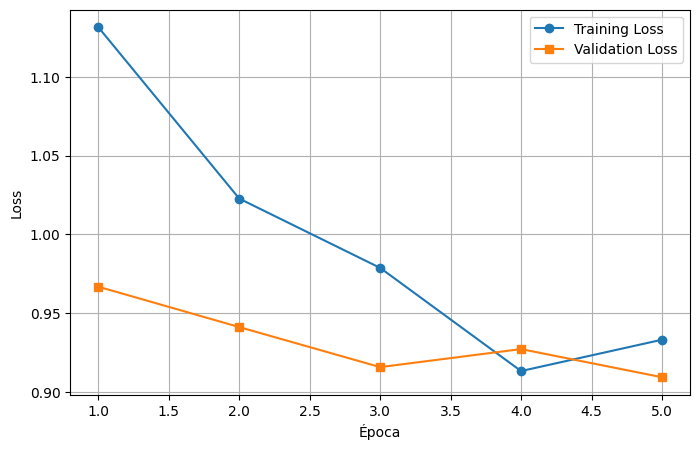

Best model loaded from: ./results/checkpoint-64


Results in Test Set: {'eval_loss': 0.9448987245559692, 'eval_accuracy': 0.5185185185185185, 'eval_f1_score': 0.5339138002618888, 'eval_precision_master': 0.7222222222222222, 'eval_recall_master': 0.43333333333333335, 'eval_f1_master': 0.5416666666666666, 'eval_runtime': 0.7067, 'eval_samples_per_second': 152.824, 'eval_steps_per_second': 5.66, 'epoch': 5.0}


In [8]:

import random
import numpy as np
import torch
from sklearn.metrics import classification_report

seed = 49

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Avoid parallelism warning in tokenization
os.environ["TOKENIZERS_PARALLELISM"] = "false"


def training_model(train_data, valid_data):

    """
    Trains the BERTOnlyClassifier using Hugging Face Trainer API.

    Args:
        train_data (Dataset): The training dataset in Hugging Face Dataset format.
        valid_data (Dataset): The validation dataset in Hugging Face Dataset format.

    Returns:
        Trainer: The trained Hugging Face Trainer object.
    """
    num_artistas = int(artist_ids.max().item()) + 1
    model = BERTOnlyClassifier(num_labels=3, num_artistas=num_artistas)

    for module in model.classifier:
      if isinstance(module, nn.Linear):
          nn.init.xavier_uniform_(module.weight)
          if module.bias is not None:
              module.bias.data.fill_(0)

    # Training arguments
    batch_size = 32
    training_arguments = TrainingArguments(
        output_dir="./results",
        num_train_epochs=5,
        learning_rate=1e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        eval_strategy="epoch",
        logging_strategy="epoch",
        seed=seed,
        metric_for_best_model="f1_score", # Use F1-score to select the best model
        greater_is_better=True,
        load_best_model_at_end=True,
        save_strategy="epoch"
    )

    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    data_collator = DataCollatorWithPadding(tokenizer)

    # Define the Trainer
    trainer = Trainer(
        model=model,
        args=training_arguments,
        train_dataset=train_data,
        eval_dataset=valid_data,
        data_collator=data_collator,
        compute_metrics=compute_metrics_e,
        callbacks=[LossPlotCallback()]
    )

    trainer.train()
    print("Best model loaded from:", trainer.state.best_model_checkpoint)

    torch.save(model.state_dict(), "modelo_entrenado_text.pth")
    return trainer

if __name__ == "__main__":

    import torch
    from torch.utils.data import Dataset, Subset, ConcatDataset, random_split, DataLoader

    seed = 49
    generator = torch.Generator().manual_seed(seed)

    filepath = '/content/drive/My Drive/TFG/20250204_bd_tfg_canciones.csv'
    df = load_dataset(filepath)

    # Necessary columns for the model with only lyrics
    df = df[["ID", "ID Obra Maestra", "Letra", "Etiquetado: Tipo de Composición", "Intérprete"]]

    df = tokenize_data(df)
    df = encode_name_artist(df)
    df = encode_cover_type(df)
    df = originals_to_train(df)

    df = df[["Tipo_codificado", "Intérprete_codificado", "tokenized", "force_train"]]
    df = df.reset_index(drop=True)

    # Convert to tensors
    input_ids = torch.stack([row["tokenized"]["input_ids"] for _, row in df.iterrows()])
    attention_mask = torch.stack([row["tokenized"]["attention_mask"] for _, row in df.iterrows()])
    labels = torch.tensor(df["Tipo_codificado"].tolist(), dtype=torch.long)
    artist_ids = torch.tensor(df["Intérprete_codificado"].tolist(), dtype=torch.long)
    force_train = df["force_train"].tolist()

    data_dict = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
        "force_train": force_train,
        "artist_ids": artist_ids
    }


    # Dataset with only text
    class TextOnlyDataset(Dataset):
        def __init__(self, data):
            self.input_ids = data["input_ids"]
            self.attention_mask = data["attention_mask"]
            self.labels = data["labels"]
            self.artist_ids = data["artist_ids"]

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            return {
              "input_ids": self.input_ids[idx],
              "attention_mask": self.attention_mask[idx],
              "labels": self.labels[idx],
              "artist_ids": self.artist_ids[idx]
          }
    full_dataset = TextOnlyDataset(data_dict)

    # Forced separation
    force_train_indices = [i for i, f in enumerate(data_dict["force_train"]) if f]

    non_forced_master_indices = [
        i for i in range(len(full_dataset))
        if i not in force_train_indices and data_dict["labels"][i] == 0
    ]

    # Indexes of classes 1 and 2 (No original / Original Cover)
    non_master_indices = [
        i for i in range(len(full_dataset))
        if i not in force_train_indices and data_dict["labels"][i] != 0
    ]


    force_train_dataset = torch.utils.data.Subset(full_dataset, force_train_indices)
    remaining_dataset = torch.utils.data.Subset(full_dataset, non_master_indices)
    non_forced_master_dataset = torch.utils.data.Subset(full_dataset, non_forced_master_indices)

    # Split the remaining dataset (only classes 1 and 2)
    remaining_len = len(remaining_dataset)
    train_len = int(0.75 * remaining_len)
    val_len = int(0.125 * remaining_len)
    test_len = remaining_len - train_len - val_len

    generator = torch.Generator().manual_seed(seed)
    train_remain, val_remain, test_remain = random_split(remaining_dataset, [train_len, val_len, test_len], generator=generator)

    # Include the remaining Masters to val/test
    midpoint = len(non_forced_master_dataset) // 2
    val_extra = torch.utils.data.Subset(non_forced_master_dataset, list(range(0, midpoint)))
    test_extra = torch.utils.data.Subset(non_forced_master_dataset, list(range(midpoint, len(non_forced_master_dataset))))

    val_dataset = torch.utils.data.ConcatDataset([val_remain, val_extra])
    test_dataset = torch.utils.data.ConcatDataset([test_remain, test_extra])

    final_train_dataset = torch.utils.data.ConcatDataset([force_train_dataset, train_remain])



    # Recover the original indexes of the Subset and ConcatDataset objects

    train_remain_indices = [non_master_indices[i] for i in train_remain.indices]

    val_remain_indices = [non_master_indices[i] for i in val_remain.indices]

    test_remain_indices = [non_master_indices[i] for i in test_remain.indices]

    val_extra_indices = non_forced_master_indices[:midpoint]
    test_extra_indices = non_forced_master_indices[midpoint:]

    force_train_indices = force_train_indices  # already original indexes
    train_indices = force_train_indices + train_remain_indices

    val_indices = val_remain_indices + val_extra_indices
    test_indices = test_remain_indices + test_extra_indices


    val_dataset = Subset(full_dataset, val_indices)
    test_dataset = Subset(full_dataset, test_indices)
    train_dataset = Subset(full_dataset, train_indices)




    trainer = training_model(train_dataset, val_dataset)

    results = trainer.evaluate(test_dataset)

    print("Results in Test Set:", results)






To save train, validation and test indexes

In [10]:

import json

# Convert indexes to lists of integers in case there are numpy.int64 type objects
split_indices = {
    "train": list(map(int, train_indices)),
    "val": list(map(int, val_indices)),
    "test": list(map(int, test_indices))
}

# Save as JSON
with open("split_indices.json", "w") as f:
    json.dump(split_indices, f, indent=2)



To obtain metrics results

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions directly from the trainer
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids

# Create the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

print(cm)

# Generate metrics table
print(classification_report(true_labels, pred_labels, target_names=["Master", "No Original Cover", "Original Cover"]))


[[26 28  6]
 [ 9 13  8]
 [ 1  0 17]]
                   precision    recall  f1-score   support

           Master       0.72      0.43      0.54        60
No Original Cover       0.32      0.43      0.37        30
   Original Cover       0.55      0.94      0.69        18

         accuracy                           0.52       108
        macro avg       0.53      0.60      0.53       108
     weighted avg       0.58      0.52      0.52       108



To see the distribution of categories in the training dataset

In [37]:
from collections import Counter

train_labels = [full_dataset[i]["labels"].item() for i in train_indices]
train_counts = Counter(train_labels)

print("Distribution in training:")
for clase, count in sorted(train_counts.items()):
    print(f"Class {clase}: {count} examples")

Distribution in training:
Class 0: 206 examples
Class 1: 142 examples
Class 2: 142 examples


### USING AS OBJECTIVE METRIC: PRECISION MASTER

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision Master,Recall Master,F1 Master
1,1.131500,0.966761,0.613208,0.514738,0.641026,0.847458,0.729927
2,1.022700,0.941125,0.509434,0.496229,0.620000,0.525424,0.568807
3,0.978700,0.915708,0.500000,0.516921,0.650000,0.440678,0.525253
4,0.913200,0.927140,0.509434,0.527881,0.666667,0.440678,0.530612
5,0.933100,0.909322,0.509434,0.527881,0.666667,0.440678,0.530612


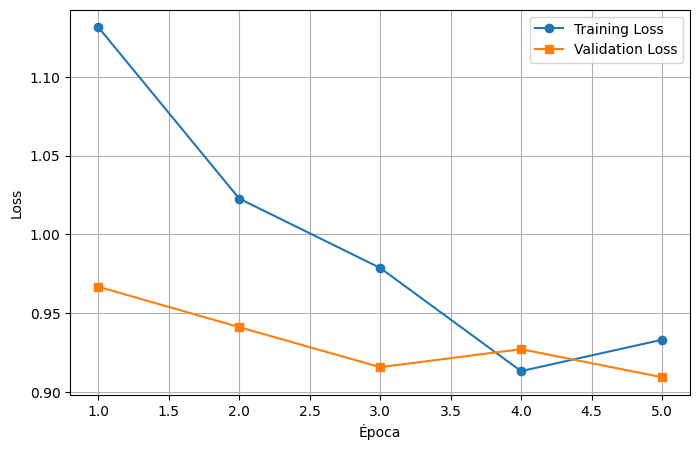

Results in Test Set: {'eval_loss': 0.9448907375335693, 'eval_accuracy': 0.5185185185185185, 'eval_f1_score': 0.5339138002618888, 'eval_precision_master': 0.7222222222222222, 'eval_recall_master': 0.43333333333333335, 'eval_f1_master': 0.5416666666666666, 'eval_runtime': 0.7043, 'eval_samples_per_second': 153.343, 'eval_steps_per_second': 5.679, 'epoch': 5.0}


In [12]:
import random
import numpy as np
import torch

from sklearn.metrics import precision_score, accuracy_score, f1_score


seed = 49

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Avoid parallelism warning in tokenization
os.environ["TOKENIZERS_PARALLELISM"] = "false"



def training_model(train_data, valid_data):
    """
    Trains the BERTOnlyClassifier using Hugging Face Trainer API.

    Args:
        train_data (Dataset): The training dataset in Hugging Face Dataset format.
        valid_data (Dataset): The validation dataset in Hugging Face Dataset format.

    Returns:
        Trainer: The trained Hugging Face Trainer object.
    """
    num_artistas = int(artist_ids.max().item()) + 1
    model = BERTOnlyClassifier(num_labels=3, num_artistas=num_artistas)

    for module in model.classifier:
      if isinstance(module, nn.Linear):
          nn.init.xavier_uniform_(module.weight)
          if module.bias is not None:
              module.bias.data.fill_(0)


    batch_size = 32
    training_arguments = TrainingArguments(
        output_dir="./results",
        num_train_epochs=5,
        learning_rate=1e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        eval_strategy="epoch",
        logging_strategy="epoch",
        seed=seed,
        metric_for_best_model="precision_master", # Use precision_master to select the best model
        greater_is_better=True,
        load_best_model_at_end=True,
        save_strategy="epoch"
    )

    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    data_collator = DataCollatorWithPadding(tokenizer)

    trainer = Trainer(
        model=model,
        args=training_arguments,
        train_dataset=train_data,
        eval_dataset=valid_data,
        data_collator=data_collator,
        compute_metrics=compute_metrics_e,
        callbacks=[LossPlotCallback()]
    )

    trainer.train()
    torch.save(model.state_dict(), "modelo_entrenado_text.pth")
    return trainer


if __name__ == "__main__":
    seed = 49
    generator = torch.Generator().manual_seed(seed)

    filepath = '/content/drive/My Drive/TFG/20250204_bd_tfg_canciones.csv'

    df = load_dataset(filepath)

    # Necessary columns for the model with only lyrics
    df = df[["ID", "ID Obra Maestra", "Letra", "Etiquetado: Tipo de Composición", "Intérprete"]]

    df = tokenize_data(df)

    df = encode_name_artist(df)
    df = encode_cover_type(df)

    df = originals_to_train(df)

    df = df[["Tipo_codificado", "Intérprete_codificado", "tokenized", "force_train"]]

    df = df.reset_index(drop=True)

    # Convert to tensors
    input_ids = torch.stack([row["tokenized"]["input_ids"] for _, row in df.iterrows()])
    attention_mask = torch.stack([row["tokenized"]["attention_mask"] for _, row in df.iterrows()])
    labels = torch.tensor(df["Tipo_codificado"].tolist(), dtype=torch.long)
    artist_ids = torch.tensor(df["Intérprete_codificado"].tolist(), dtype=torch.long)
    force_train = df["force_train"].tolist()

    data_dict = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
        "force_train": force_train,
        "artist_ids": artist_ids
    }



    full_dataset = TextOnlyDataset(data_dict)

    # Load the indexes previously saved
    with open("split_indices.json") as f:
        splits = json.load(f)

    train_dataset = Subset(full_dataset, splits["train"])
    val_dataset = Subset(full_dataset, splits["val"])
    test_dataset = Subset(full_dataset, splits["test"])


    trainer = training_model(train_dataset, val_dataset)

    results = trainer.evaluate(test_dataset)

    print("Results in Test Set:", results)




To obtain metrics results

In [12]:
from sklearn.metrics import classification_report

# Get predictions directly from the trainer
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids

# Create the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

print(cm)

# Generate metrics table
print(classification_report(true_labels, pred_labels, target_names=["Master", "No Original Cover", "Original Cover"]))

[[26 28  6]
 [ 9 13  8]
 [ 1  0 17]]
                   precision    recall  f1-score   support

           Master       0.72      0.43      0.54        60
No Original Cover       0.32      0.43      0.37        30
   Original Cover       0.55      0.94      0.69        18

         accuracy                           0.52       108
        macro avg       0.53      0.60      0.53       108
     weighted avg       0.58      0.52      0.52       108



# MODELS WITH ONLY SPECTROGRAMS OF SONGS



### CODE TO CREATE THE SPECTROGRAMS OF THE AUDIOS (MP3)



In [38]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Folder of input and output
input_folder = "/content/drive/My Drive/TFG/Audios/"
output_folder = "/content/drive/My Drive/TFG/Espectogramas/"

os.makedirs(output_folder, exist_ok=True)


def save_spectrogram(audio_path, output_path):
    """
    Generates and saves a log-scaled spectrogram image using STFT from an audio file.

    Args:
        audio_path (str): Path to the input audio file.
        output_path (str): Path where the resulting spectrogram image will be saved.
    """
    y, sr = librosa.load(audio_path, sr=None)
    D = np.abs(librosa.stft(y))**2  #Compute the Short-Time Fourier Transform (STFT)

    S = librosa.power_to_db(D, ref=np.max)  # Convert to logarithm scale

    # Create the spectrogram image
    plt.figure(figsize=(4, 4))
    librosa.display.specshow(S, sr=sr, x_axis=None, y_axis="log")
    plt.axis("off")
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0)
    plt.close()



# Process all files in the folder
audio_files = [f for f in os.listdir(input_folder) if f.endswith(".mp3")]

#audio_files = audio_files[705:]

for file in tqdm(audio_files, desc="Generando espectrogramas"):
    audio_path = os.path.join(input_folder, file)
    output_path = os.path.join(output_folder, file.replace(".wav", ".png").replace(".mp3", ".png"))
    if os.path.exists(output_path):
        continue
    save_spectrogram(audio_path, output_path)

print(f"Were generated {len(audio_files)} spectrograms in {output_folder}")


Generando espectrogramas: 100%|██████████| 2/2 [00:00<00:00, 2718.28it/s]

Were generated 2 spectrograms in /content/drive/My Drive/TFG/Espectogramas/


### USING AS OBJECTIVE METRIC: F1-SCORE

In [24]:
from transformers import AutoImageProcessor
from PIL import Image
import torch
import glob

feature_extractor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

def load_spectrogram_by_id_prefix(id_value):
    """
    Loads a spectrogram image corresponding to a given ID, converts it to RGB,
    and processes it using a pretrained Vision Transformer feature extractor.

    Args:
        id_value (nt): The ID used to locate the corresponding spectrogram image file.

    Returns:
        torch.Tensor: A 3x224x224 tensor representing the preprocessed spectrogram image.
                      If no matching image is found or an error occurs, returns a zero tensor.
    """
    try:
        str_id = str(id_value)

        base_path = "/content/drive/My Drive/TFG/Espectogramas"
        pattern = os.path.join(base_path, f"{str_id} - *.png")

        # Search for files starting with that pattern
        matches = glob.glob(pattern)

        if not matches:
            raise FileNotFoundError(f"No file was found with pattern {pattern}")

        image_path = matches[0]  # We use the first one if there are several

        image = Image.open(image_path).convert("RGB")
        encoding = feature_extractor(images=image, return_tensors="pt")
        return encoding["pixel_values"].squeeze(0)

    except Exception as e:
        print(f"[ERROR] ID {id_value} → {e}")
        return torch.zeros(3, 224, 224)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [25]:
from transformers import ViTModel
import torch.nn as nn

class ViTOnlyClassifier(nn.Module):

    def __init__(self, num_labels=3):
        """
        Initializes a classifier that uses a pretrained Vision Transformer (ViT)
        to classify spectrogram images into one of the classes.

        Args:
            num_labels (int): Number of output classes for classification.
        """
        super().__init__()
        self.vision_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )
        self.class_weights = torch.tensor([1.55, 1.7, 1.45])


    def forward(self, spectrograms=None, labels=None):
        """
        Forward pass of the model.

        Args:
            spectrograms (torch.Tensor): Batch of image tensors representing spectrograms.
            labels (torch.Tensor, optional): True labels for computing loss.

        Returns:
            dict: Always includes 'logits'. If labels are given, also includes 'loss'.
        """

        vision_out = self.vision_model(pixel_values=spectrograms)
        vision_embed = vision_out.pooler_output

        logits = self.classifier(vision_embed)

        if labels is not None:
            weights = self.class_weights.to(logits.device)
            loss = nn.functional.cross_entropy(logits, labels, weight=weights)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}


def custom_collator(batch):

    """
    Custom collator function to prepare batches of spectrogram images and labels.

    Args:
        batch (list of dict): Each item in the batch is a dict with keys:
            - 'spectrograms': tensor image representation of a spectrogram
            - 'labels': int label

    Returns:
        dict: A dictionary with two keys:
            - 'spectrograms': Tensor of image tensors representing spectrograms
            - 'labels': Tensor of labels
    """
    spectrograms = []
    labels = []

    for i, item in enumerate(batch):
        try:
            spectrograms.append(item["spectrograms"])
            labels.append(item["labels"])
        except Exception as e:
            print(f"[ERROR] Item {i} in the batch failed: {e}")
            continue

    return {
        "spectrograms": torch.stack(spectrograms),
        "labels": torch.tensor(labels, dtype=torch.long)
    }


def torch_data_vit_only(df):
    """
    Processes a DataFrame to extract and stack spectrogram tensors and their corresponding labels.

    Args:
        df (pd.DataFrame): The input DataFrame.
    Returns:
        dict: A dictionary with:
            - 'spectrograms': Tensor of image tensors representing spectrograms
            - 'labels': Tensor of labels
            - 'force_train': list of booleans
    """

    spectrograms = []
    labels = []
    force_train = []

    for idx, row in df.iterrows():
        spec = row.get("spectrogram_tensor")

        if isinstance(spec, torch.Tensor) and spec.shape == (3, 224, 224):
            spectrograms.append(spec)
            labels.append(row["Tipo_codificado"])
            force_train.append(row["force_train"])
        else:
            print(f"[WARNING] Invalid spectrogram in row {idx}: {type(spec)} {getattr(spec, 'shape', None)}")

    if len(spectrograms) == 0:
        raise RuntimeError("torch_data_vit_only → There is no valid spectrogram.")

    return {
        "spectrograms": torch.stack(spectrograms),
        "labels": torch.tensor(labels, dtype=torch.long),
        "force_train": force_train
    }


# Create dataset
class SpectrogramDataset(Dataset):
    def __init__(self, data_dict):
        self.spectrograms = data_dict["spectrograms"]
        self.labels = data_dict["labels"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "spectrograms": self.spectrograms[idx],
            "labels": self.labels[idx]
        }

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision Master,Recall Master,F1 Master
1,1.065600,0.947414,0.556604,0.238384,0.556604,1.000000,0.715152
2,1.008500,0.856336,0.764151,0.674603,0.728395,1.000000,0.842857
3,0.955600,0.789779,0.849057,0.797980,0.808219,1.000000,0.893939
4,0.923100,0.750110,0.896226,0.848795,0.907692,1.000000,0.951613
5,0.894800,0.738361,0.896226,0.848795,0.907692,1.000000,0.951613


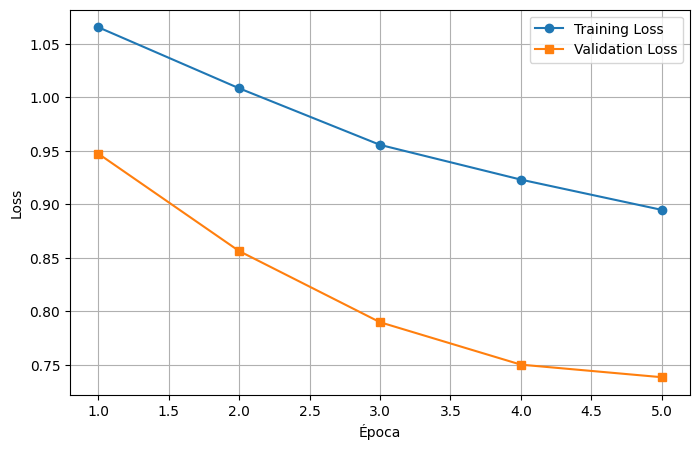

Resultados en Test Set: {'eval_loss': 0.8732495903968811, 'eval_accuracy': 0.7314814814814815, 'eval_f1_score': 0.7213024671956415, 'eval_precision_master': 0.8936170212765957, 'eval_recall_master': 0.7, 'eval_f1_master': 0.7850467289719626, 'eval_runtime': 0.3143, 'eval_samples_per_second': 343.649, 'eval_steps_per_second': 12.728, 'epoch': 5.0}


In [26]:
import torch.nn as nn
from transformers import ViTModel

seed = 49

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



def training_model(train_data, valid_data):
    """
    Trains the ViTOnlyClassifier using Hugging Face Trainer API.

    Args:
        train_data (Dataset): The training dataset in Hugging Face Dataset format.
        valid_data (Dataset): The validation dataset in Hugging Face Dataset format.

    Returns:
        Trainer: The trained Hugging Face Trainer object.
    """
    model = ViTOnlyClassifier(num_labels=3)

    # Training arguments
    batch_size = 32
    training_arguments = TrainingArguments(
        output_dir="./results",
        num_train_epochs=5,
        learning_rate=1e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        eval_strategy="epoch",
        logging_strategy="epoch",
        seed=seed,
        metric_for_best_model="f1_score", # Use F1-score to select the best model
        greater_is_better=True,
        load_best_model_at_end=True,
        save_strategy="epoch"
    )

    # Define the Trainer
    trainer = Trainer(
        model=model,
        args=training_arguments,
        train_dataset=train_data,
        eval_dataset=valid_data,
        data_collator=custom_collator,
        compute_metrics=compute_metrics_e,
        callbacks=[LossPlotCallback()]
    )
    trainer.train()
    torch.save(model.state_dict(), "modelo_entrenado_spectogram.pth")

    return trainer


if __name__ == "__main__":
    seed = 49
    generator = torch.Generator().manual_seed(seed)

    import torch

    filepath = '/content/drive/My Drive/TFG/20250204_bd_tfg_canciones.csv'
    df = load_dataset(filepath)

    # Only necessary columns
    df = df[["ID", "ID Obra Maestra", "Etiquetado: Tipo de Composición", "Intérprete", "Audio"]]

    # Load spectrograms tensors from files .png
    df["spectrogram_tensor"] = df["ID"].apply(load_spectrogram_by_id_prefix)

    df = encode_name_artist(df)
    df = encode_cover_type(df)
    df = originals_to_train(df)

    # Only necessary columns for spectrograms
    df = df[["Tipo_codificado", "Intérprete_codificado", "spectrogram_tensor", "force_train"]]

    df = df.reset_index(drop=True)

    data_dict = torch_data_vit_only(df)



    full_dataset = SpectrogramDataset(data_dict)

    # Load the indexes previously saved
    with open("split_indices.json") as f:
        splits = json.load(f)

    train_dataset = Subset(full_dataset, splits["train"])
    val_dataset = Subset(full_dataset, splits["val"])
    test_dataset = Subset(full_dataset, splits["test"])

    trainer = training_model(train_dataset, val_dataset)

    results = trainer.evaluate(test_dataset)
    print("Resultados en Test Set:", results)




To obtain metrics results

In [27]:
from sklearn.metrics import classification_report

# Get predictions directly from the trainer
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids

# Create the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

print(cm)

# Generate metrics table
print(classification_report(true_labels, pred_labels, target_names=["Master", "No Original Cover", "Original Cover"]))

[[42 13  5]
 [ 5 19  6]
 [ 0  0 18]]
                   precision    recall  f1-score   support

           Master       0.89      0.70      0.79        60
No Original Cover       0.59      0.63      0.61        30
   Original Cover       0.62      1.00      0.77        18

         accuracy                           0.73       108
        macro avg       0.70      0.78      0.72       108
     weighted avg       0.76      0.73      0.73       108



### USING AS OBJECTIVE METRIC: PRECISION MASTER

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision Master,Recall Master,F1 Master
1,1.065600,0.947423,0.556604,0.238384,0.556604,1.000000,0.715152
2,1.008400,0.855595,0.764151,0.674603,0.728395,1.000000,0.842857
3,0.955200,0.789652,0.839623,0.780954,0.797297,1.000000,0.887218
4,0.922700,0.749587,0.896226,0.848795,0.907692,1.000000,0.951613
5,0.894500,0.738034,0.896226,0.848795,0.907692,1.000000,0.951613


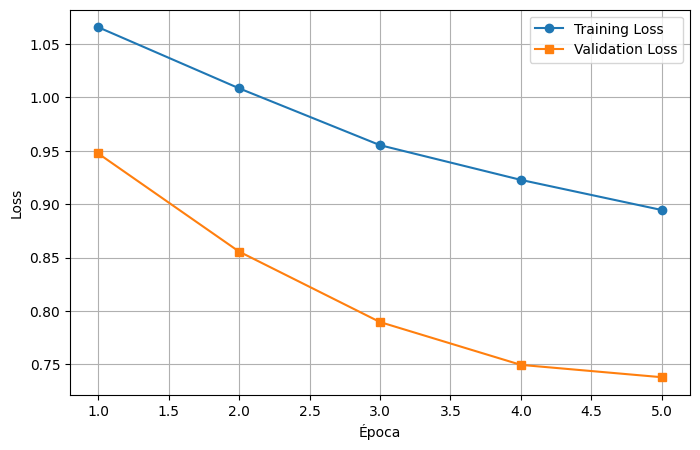

Resultados en Test Set: {'eval_loss': 0.8732625246047974, 'eval_accuracy': 0.7314814814814815, 'eval_f1_score': 0.7213024671956415, 'eval_precision_master': 0.8936170212765957, 'eval_recall_master': 0.7, 'eval_f1_master': 0.7850467289719626, 'eval_runtime': 0.319, 'eval_samples_per_second': 338.542, 'eval_steps_per_second': 12.539, 'epoch': 5.0}


In [28]:
import torch.nn as nn
from transformers import ViTModel

seed = 49

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



def training_model(train_data, valid_data):
    """
    Trains the ViTOnlyClassifier using Hugging Face Trainer API.

    Args:
        train_data (Dataset): The training dataset in Hugging Face Dataset format.
        valid_data (Dataset): The validation dataset in Hugging Face Dataset format.

    Returns:
        Trainer: The trained Hugging Face Trainer object.
    """
    model = ViTOnlyClassifier(num_labels=3)

    # Training arguments
    batch_size = 32
    training_arguments = TrainingArguments(
        output_dir="./results",
        num_train_epochs=5,
        learning_rate=1e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        eval_strategy="epoch",
        logging_strategy="epoch",
        seed=seed,
        metric_for_best_model="precision_master", # Use precision master to select the best model
        greater_is_better=True,
        load_best_model_at_end=True,
        save_strategy="epoch"
    )

    # Define the Trainer
    trainer = Trainer(
        model=model,
        args=training_arguments,
        train_dataset=train_data,
        eval_dataset=valid_data,
        data_collator=custom_collator,
        compute_metrics=compute_metrics_e,
        callbacks=[LossPlotCallback()]
    )
    trainer.train()
    torch.save(model.state_dict(), "modelo_entrenado_spectogram.pth")

    return trainer


if __name__ == "__main__":
    seed = 49
    generator = torch.Generator().manual_seed(seed)

    import torch

    filepath = '/content/drive/My Drive/TFG/20250204_bd_tfg_canciones.csv'
    df = load_dataset(filepath)

    # Only necessary columns
    df = df[["ID", "ID Obra Maestra", "Etiquetado: Tipo de Composición", "Intérprete", "Audio"]]

    # Load spectrograms tensors from files .png
    df["spectrogram_tensor"] = df["ID"].apply(load_spectrogram_by_id_prefix)

    df = encode_name_artist(df)
    df = encode_cover_type(df)
    df = originals_to_train(df)

    # Only necessary columns for spectrograms
    df = df[["Tipo_codificado", "Intérprete_codificado", "spectrogram_tensor", "force_train"]]

    df = df.reset_index(drop=True)

    data_dict = torch_data_vit_only(df)

    full_dataset = SpectrogramDataset(data_dict)

    # Load the indexes previously saved
    with open("split_indices.json") as f:
        splits = json.load(f)

    train_dataset = Subset(full_dataset, splits["train"])
    val_dataset = Subset(full_dataset, splits["val"])
    test_dataset = Subset(full_dataset, splits["test"])

    trainer = training_model(train_dataset, val_dataset)

    results = trainer.evaluate(test_dataset)
    print("Resultados en Test Set:", results)

To obtain metrics results

In [29]:
from sklearn.metrics import classification_report

# Get predictions directly from the trainer
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids

# Create the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

print(cm)

# Generate metrics table
print(classification_report(true_labels, pred_labels, target_names=["Master", "No Original Cover", "Original Cover"]))

[[42 13  5]
 [ 5 19  6]
 [ 0  0 18]]
                   precision    recall  f1-score   support

           Master       0.89      0.70      0.79        60
No Original Cover       0.59      0.63      0.61        30
   Original Cover       0.62      1.00      0.77        18

         accuracy                           0.73       108
        macro avg       0.70      0.78      0.72       108
     weighted avg       0.76      0.73      0.73       108



# MULTIMODAL MODELS WITH SPECTROGRAMS AND LYRICS OF SONGS

In [30]:
import glob
import os
from PIL import Image
from transformers import AutoImageProcessor, BertModel, ViTModel
import torch


feature_extractor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

def load_spectrogram_by_id_prefix(id_value):
    """
    Loads a spectrogram image corresponding to a given ID, converts it to RGB,
    and processes it using a pretrained Vision Transformer feature extractor.

    Args:
        id_value (nt): The ID used to locate the corresponding spectrogram image file.

    Returns:
        torch.Tensor: A 3x224x224 tensor representing the preprocessed spectrogram image.
                      If no matching image is found or an error occurs, returns a zero tensor.
    """
    try:
        str_id = str(id_value)

        base_path = "/content/drive/My Drive/TFG/Espectogramas"
        pattern = os.path.join(base_path, f"{str_id} - *.png")

        # Search for files starting with that pattern
        matches = glob.glob(pattern)

        if not matches:
            raise FileNotFoundError(f"No file was found with pattern {pattern}")

        image_path = matches[0] # We use the first one if there are several

        image = Image.open(image_path).convert("RGB")
        encoding = feature_extractor(images=image, return_tensors="pt")
        return encoding["pixel_values"].squeeze(0)

    except Exception as e:
        print(f"[ERROR] ID {id_value} → {e}")
        return torch.zeros(3, 224, 224)




import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, ViTModel



class BERTWithViT(nn.Module):
    def __init__(self, num_labels=3, num_artists=500):
        """
        Multimodal classifier that combines BERT (for text) and ViT (for spectrogram).

        Args:
            num_labels (int): Number of output classes.
            num_artists (int): Number of unique artist IDs to embed.
        """
        super().__init__()
        self.num_labels = num_labels


        self.text_model = BertModel.from_pretrained("bert-base-uncased")
        self.vision_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

        self.text_artist_embed = nn.Embedding(num_artists, 32)
        self.vision_artist_embed = nn.Embedding(num_artists, 32)

        self.text_classifier = nn.Sequential(
            nn.Linear(768 + 32, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

        self.vision_classifier = nn.Sequential(
            nn.Linear(768 + 32, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )


        self.text_weight = nn.Parameter(torch.tensor(0.3))  # Start with 30% text
        self.vision_weight = nn.Parameter(torch.tensor(0.7))  # 70% spectograms

        self.class_weights = torch.tensor([1.55, 1.75, 1.4])


    def forward(self, input_ids=None, attention_mask=None, spectrograms=None,
                artist_ids=None, labels=None):

        """
        Forward pass for the multimodal classifier combining BERT (text) and ViT (image) branches.

        Args:
            input_ids (torch.Tensor): Input IDs for BERT (batch_size x seq_len).
            attention_mask (torch.Tensor): Attention mask for BERT input.
            spectrograms (torch.Tensor): Image tensors (batch_size x 3 x 224 x 224).
            artist_ids (torch.Tensor): Artist IDs for both branches (batch_size).
            labels (torch.Tensor): Ground truth class labels.

        Returns:
            dict: Includes combined logits, individual logits (text & vision), and optionally loss & weights.
        """

        text_out = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_artist = self.text_artist_embed(artist_ids)
        text_combined = torch.cat([text_out.pooler_output, text_artist], dim=1)
        text_logits = self.text_classifier(text_combined)

        vision_out = self.vision_model(pixel_values=spectrograms)
        vision_artist = self.vision_artist_embed(artist_ids)
        vision_combined = torch.cat([vision_out.pooler_output, vision_artist], dim=1)
        vision_logits = self.vision_classifier(vision_combined)

        # Normalize weights so that they add up to 1
        total_weight = torch.abs(self.text_weight) + torch.abs(self.vision_weight)
        norm_text_weight = torch.abs(self.text_weight) / total_weight
        norm_vision_weight = torch.abs(self.vision_weight) / total_weight

        logits = norm_text_weight * text_logits + norm_vision_weight * vision_logits

        if labels is not None:
            weights = self.class_weights.to(logits.device)
            loss = F.cross_entropy(logits, labels, weight=weights)

            return {
                "loss": loss,
                "logits": logits,
                "text_logits": text_logits,
                "vision_logits": vision_logits,
                "weights": torch.tensor([norm_text_weight, norm_vision_weight])
            }
        else:
            return {
                "logits": logits,
                "text_logits": text_logits,
                "vision_logits": vision_logits
            }




from torch.utils.data import Dataset

class MultimodalDataset(Dataset):
    def __init__(self, data_dict):
        self.input_ids = data_dict["input_ids"]
        self.attention_mask = data_dict["attention_mask"]
        self.spectrograms = data_dict["spectrograms"]
        self.labels = data_dict["labels"]
        self.artist_ids = data_dict["artist_ids"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "spectrograms": self.spectrograms[idx],
            "labels": self.labels[idx],
            "artist_ids": self.artist_ids[idx]
        }



Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [31]:
from datasets import Dataset

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(texts):
    """
    Function to tokenize text using the BERT tokenizer.

    Arg:
        texts (str): a text string to tokenize.

    Returns:
        dict: a dictionary with the tokenized text.
    """
    tokenized = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    return {key: val.squeeze(0) for key, val in tokenized.items()}


def load_dataset(filepath):
    """
    Function to load a dataset knowing the filepath.

    Arg:
        filepath (str): path to the CSV file.

    Returns:
        pd.DataFrame: DataFrame containing the data from the file.
    """
    return pd.read_csv(filepath, sep=";", encoding="utf-8")


def tokenize_data(df):
    """
    Applies the tokenizer function to the 'Letra' column of the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The same DataFrame with an additional 'tokenized' column,
                      containing the tokenized version of each song lyric.
    """
    df["tokenized"] = df["Letra"].apply(tokenize_function)
    return df


def encode_name_artist(df):
    """
    Encodes the artist name column into numerical labels.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The same DataFrame with a new column 'Intérprete_codificado',
                      where each unique artist name is replaced by an integer label.
    """
    artist_cod = LabelEncoder()
    df["Intérprete_codificado"] = artist_cod.fit_transform(df["Intérprete"])
    return df


def encode_cover_type(df):
    """
    Encodes the different composition categories.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The same DataFrame with a new column 'Tipo_codificado',
                      where each composition type is represented by an integer.
    """

    type_cod = LabelEncoder()
    df["Tipo_codificado"] = type_cod.fit_transform(df["Etiquetado: Tipo de Composición"])
    return df


def torch_data(df):
    """
    Converts a DataFrame with tokenized text and spectrogram tensors
    into a dictionary of PyTorch tensors ready for training.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        dict: Dictionary with the following keys:
            - 'input_ids': tensor of token IDs
            - 'attention_mask': tensor of attention masks
            - 'labels': tensor of class labels
            - 'artist_ids': tensor of encoded artist IDs
            - 'spectrograms': tensor of spectrogram images
            - 'force_train': list of bools for training constraints
    """

    input_ids, attention_masks, spectrograms = [], [], []
    valid_indices = []

    for idx, row in df.iterrows():
        tokenized = row["tokenized"]
        try:
            if not isinstance(tokenized, dict) or "input_ids" not in tokenized:
                print(f"[ERROR] Invalid tokenization in row {idx}")
                continue

            input_ids.append(tokenized["input_ids"].clone().detach())
            attention_masks.append(tokenized["attention_mask"].clone().detach())
            spectrograms.append(row["spectrogram_tensor"].clone().detach())
            valid_indices.append(idx)

        except Exception as e:
            print(f"[ERROR] Fail in row {idx}: {e}")
            continue

    df = df.loc[valid_indices].reset_index(drop=True)

    data = {
        "input_ids": torch.stack(input_ids),
        "attention_mask": torch.stack(attention_masks),
        "labels": torch.tensor(df["Tipo_codificado"].tolist(), dtype=torch.long),
        "artist_ids": torch.tensor(df["Intérprete_codificado"].tolist(), dtype=torch.long),
        "spectrograms": torch.stack(spectrograms),
        "force_train": df["force_train"].tolist()
    }

    return data


def custom_collator(batch):
    """
    Custom collate function to create batches from a multimodal dataset.

    Args:
        batch (list): List of items from the dataset.

    Returns:
        dict: A batch dictionary with stacked tensors ready for the model.
    """

    input_ids = []
    attention_mask = []
    spectrograms = []
    labels = []
    artist_ids = []

    for i, item in enumerate(batch):
        try:
            ids = item["input_ids"]
            mask = item["attention_mask"]
            artist = item["artist_ids"]

            if isinstance(ids, list):
                ids = torch.tensor(ids, dtype=torch.long)
            if isinstance(mask, list):
                mask = torch.tensor(mask, dtype=torch.long)
            if isinstance(artist, list):
                artist = torch.tensor(artist, dtype=torch.long)

            input_ids.append(ids)
            attention_mask.append(mask)
            spectrograms.append(item["spectrograms"])
            labels.append(item["labels"])
            artist_ids.append(artist)
        except Exception as e:
            print(f"[ERROR] Item {i} in the batch failed: {e}")
            continue

    return {
        "input_ids": torch.stack(input_ids),
        "attention_mask": torch.stack(attention_mask),
        "spectrograms": torch.stack(spectrograms),
        "labels": torch.tensor(labels, dtype=torch.long),
        "artist_ids": torch.stack(artist_ids)  # ← incluirlo aquí
    }




def originals_to_train(df):
    """
    Flags original compositions that should be included in the train dataset.

    The logic is:
    - For each group of songs with the same 'ID Obra Maestra':
        - If there is at least one cover version, then we want to include the original in training.

    - Adds two new columns:
        - 'is_original': True if the song is the original version (ID == ID Obra Maestra)
        - 'force_train': True if it is an original composition and it has at least one cover

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The same DataFrame with two new columns:'is_original' and 'force_train'.
    """
    df["is_original"] = df["ID"] == df["ID Obra Maestra"]
    covers_present = df.groupby("ID Obra Maestra")["is_original"].apply(lambda x: (x == False).any())
    df["force_train"] = df["ID Obra Maestra"].map(covers_present) & df["is_original"]
    return df



def compute_metrics_e(pred):
    """
    Computes evaluation metrics for a classification task.

    Args:
        pred (transformers.EvalPrediction): Object containing:
            - pred.label_ids: true labels (array-like)
            - pred.predictions: model outputs (logits or probabilities)

    Returns:
        dict: Dictionary of computed metrics
    """
    labels = pred.label_ids
    predictions = pred.predictions

    print(f"Type of predictions: {type(predictions)}")
    if isinstance(predictions, tuple):
        print(f"Tuple length: {len(predictions)}")
        print(f"Shapes: {[p.shape if hasattr(p, 'shape') else type(p) for p in predictions]}")

    if isinstance(predictions, tuple):
        for i, p in enumerate(predictions):
            if hasattr(p, 'shape') and len(p.shape) == 2 and p.shape[1] == 3:
                logits = p
                print(f"Using predictions[{i}] as main logits")
                break
        else:
            logits = predictions[0]
            print("No tensor with correct shape was found, using predictions[0]")
    else:
        logits = predictions

    preds = logits.argmax(-1)

    report = classification_report(labels, preds, output_dict=True, zero_division=0)

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(labels, preds)
    print("Confusion Matrix:")
    print(cm)

    return {
        "accuracy": report["accuracy"],
        "f1_score": report["macro avg"]["f1-score"],
        "precision_master": report["0"]["precision"],
        "recall_master": report["0"]["recall"],
        "f1_master": report["0"]["f1-score"]
    }

### USING AS OBJECTIVE METRIC: PRECISION MASTER

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision Master,Recall Master,F1 Master
1,1.061000,0.960569,0.603774,0.375216,0.584158,1.000000,0.737500
2,0.998100,0.902294,0.707547,0.579028,0.670455,1.000000,0.802721
3,0.956900,0.854483,0.811321,0.751543,0.776316,1.000000,0.874074
4,0.929100,0.825708,0.839623,0.786366,0.819444,1.000000,0.900763
5,0.913200,0.816457,0.849057,0.796895,0.830986,1.000000,0.907692


Type of predictions: <class 'tuple'>
Tuple length: 4
Shapes: [(106, 3), (106, 3), (106, 3), (8,)]
Using predictions[0] as main logits
Confusion Matrix:
[[59  0  0]
 [19  3  0]
 [23  0  2]]
Type of predictions: <class 'tuple'>
Tuple length: 4
Shapes: [(106, 3), (106, 3), (106, 3), (8,)]
Using predictions[0] as main logits
Confusion Matrix:
[[59  0  0]
 [18  4  0]
 [11  2 12]]
Type of predictions: <class 'tuple'>
Tuple length: 4
Shapes: [(106, 3), (106, 3), (106, 3), (8,)]
Using predictions[0] as main logits
Confusion Matrix:
[[59  0  0]
 [ 9 10  3]
 [ 8  0 17]]
Type of predictions: <class 'tuple'>
Tuple length: 4
Shapes: [(106, 3), (106, 3), (106, 3), (8,)]
Using predictions[0] as main logits
Confusion Matrix:
[[59  0  0]
 [ 7 11  4]
 [ 6  0 19]]
Type of predictions: <class 'tuple'>
Tuple length: 4
Shapes: [(106, 3), (106, 3), (106, 3), (8,)]
Using predictions[0] as main logits
Confusion Matrix:
[[59  0  0]
 [ 7 11  4]
 [ 5  0 20]]


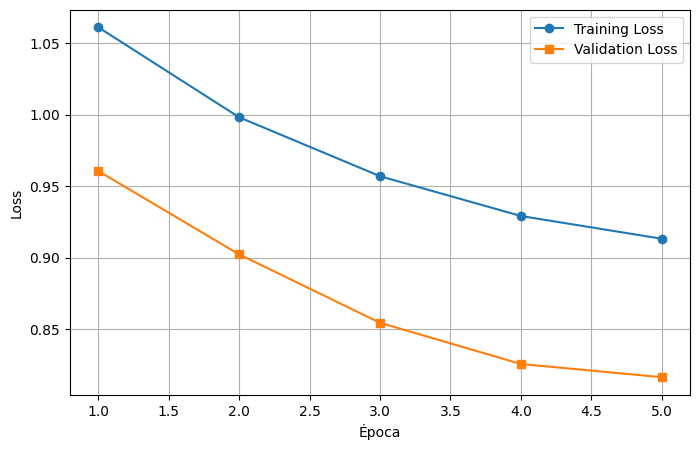

Type of predictions: <class 'tuple'>
Tuple length: 4
Shapes: [(108, 3), (108, 3), (108, 3), (8,)]
Using predictions[0] as main logits
Confusion Matrix:
[[50  6  4]
 [ 8 16  6]
 [ 1  0 17]]
Results in Test Set: {'eval_loss': 0.9023908972740173, 'eval_accuracy': 0.7685185185185185, 'eval_f1_score': 0.7370921017979842, 'eval_precision_master': 0.847457627118644, 'eval_recall_master': 0.8333333333333334, 'eval_f1_master': 0.8403361344537815, 'eval_runtime': 0.8899, 'eval_samples_per_second': 121.366, 'eval_steps_per_second': 4.495, 'epoch': 5.0}


In [32]:
from datasets import Dataset


import random
import numpy as np
import torch

seed = 49

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


os.environ["TOKENIZERS_PARALLELISM"] = "false"



def training_model(train_data, valid_data):
    """
    Trains the BERTWithViT using Hugging Face Trainer API.

    Args:
        train_data (Dataset): The training dataset in Hugging Face Dataset format.
        valid_data (Dataset): The validation dataset in Hugging Face Dataset format.

    Returns:
        Trainer: The trained Hugging Face Trainer object.
    """
    model = BERTWithViT(num_labels=3)

    batch_size = 32
    training_arguments = TrainingArguments(
        output_dir="./results",
        num_train_epochs=5,
        learning_rate=1e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        eval_strategy="epoch",
        logging_strategy="epoch",
        seed=seed,
        metric_for_best_model="precision_master", # Use precision master to select the best model
        greater_is_better=True
    )

    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    data_collator = DataCollatorWithPadding(tokenizer)

    # Define the Trainer
    trainer = Trainer(
        model=model,
        args=training_arguments,
        train_dataset=train_data,
        eval_dataset=valid_data,
        data_collator = custom_collator,
        compute_metrics=compute_metrics_e,
        callbacks=[LossPlotCallback()]
    )
    trainer.train()
    return trainer



if __name__ == "__main__":

    seed = 49
    generator = torch.Generator().manual_seed(seed)

    filepath = '/content/drive/My Drive/TFG/20250204_bd_tfg_canciones.csv'

    df = load_dataset(filepath)

    # Only necessary columns
    df = df[["ID", "ID Obra Maestra", "Letra", "Etiquetado: Tipo de Composición", "Intérprete", "Audio"]]

    df["spectrogram_tensor"] = df["ID"].apply(load_spectrogram_by_id_prefix)

    df = tokenize_data(df)
    df = encode_name_artist(df)
    df = encode_cover_type(df)
    df = originals_to_train(df)

    # Only necessary columns for the multimodal model
    df = df[["Tipo_codificado", "Intérprete_codificado", "tokenized", "force_train", "spectrogram_tensor"]]

    df = df.reset_index(drop=True)

    data_dict = torch_data(df)

    from torch.utils.data import random_split

    full_dataset = MultimodalDataset(data_dict)

    # Load the indexes previously saved
    with open("split_indices.json") as f:
        splits = json.load(f)

    train_dataset = Subset(full_dataset, splits["train"])
    val_dataset = Subset(full_dataset, splits["val"])
    test_dataset = Subset(full_dataset, splits["test"])

    trainer = training_model(train_dataset, val_dataset)

    results = trainer.evaluate(test_dataset)

    print("Results in Test Set:", results)


To obtain metrics results

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

predictions = trainer.predict(test_dataset)

logits = predictions.predictions[0]
true_labels = np.array(predictions.label_ids).flatten()

pred_labels = np.argmax(logits, axis=1)


print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

print("\n Classification results:")
print(classification_report(
    true_labels,
    pred_labels,
    target_names=["Master", "No Original Cover", "Original Cover"]
))


Type of predictions: <class 'tuple'>
Tuple length: 4
Shapes: [(108, 3), (108, 3), (108, 3), (8,)]
Using predictions[0] as main logits
Confusion Matrix:
[[50  6  4]
 [ 8 16  6]
 [ 1  0 17]]
Confusion Matrix:
[[50  6  4]
 [ 8 16  6]
 [ 1  0 17]]

 Classification results:
                   precision    recall  f1-score   support

           Master       0.85      0.83      0.84        60
No Original Cover       0.73      0.53      0.62        30
   Original Cover       0.63      0.94      0.76        18

         accuracy                           0.77       108
        macro avg       0.73      0.77      0.74       108
     weighted avg       0.78      0.77      0.76       108



### USING AS OBJECTIVE METRIC: F1-SCORE

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision Master,Recall Master,F1 Master
1,1.061000,0.960559,0.603774,0.375216,0.584158,1.000000,0.737500
2,0.998200,0.902317,0.707547,0.579028,0.670455,1.000000,0.802721
3,0.957000,0.854876,0.811321,0.751543,0.776316,1.000000,0.874074
4,0.929000,0.825680,0.839623,0.786366,0.819444,1.000000,0.900763
5,0.913000,0.816350,0.849057,0.796895,0.830986,1.000000,0.907692


Type of predictions: <class 'tuple'>
Tuple length: 4
Shapes: [(106, 3), (106, 3), (106, 3), (8,)]
Using predictions[0] as main logits
Confusion Matrix:
[[59  0  0]
 [19  3  0]
 [23  0  2]]
Type of predictions: <class 'tuple'>
Tuple length: 4
Shapes: [(106, 3), (106, 3), (106, 3), (8,)]
Using predictions[0] as main logits
Confusion Matrix:
[[59  0  0]
 [18  4  0]
 [11  2 12]]
Type of predictions: <class 'tuple'>
Tuple length: 4
Shapes: [(106, 3), (106, 3), (106, 3), (8,)]
Using predictions[0] as main logits
Confusion Matrix:
[[59  0  0]
 [ 9 10  3]
 [ 8  0 17]]
Type of predictions: <class 'tuple'>
Tuple length: 4
Shapes: [(106, 3), (106, 3), (106, 3), (8,)]
Using predictions[0] as main logits
Confusion Matrix:
[[59  0  0]
 [ 7 11  4]
 [ 6  0 19]]
Type of predictions: <class 'tuple'>
Tuple length: 4
Shapes: [(106, 3), (106, 3), (106, 3), (8,)]
Using predictions[0] as main logits
Confusion Matrix:
[[59  0  0]
 [ 7 11  4]
 [ 5  0 20]]


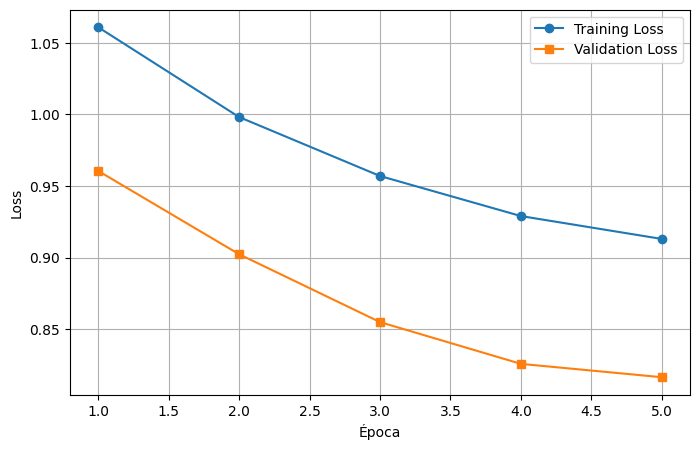

Type of predictions: <class 'tuple'>
Tuple length: 4
Shapes: [(108, 3), (108, 3), (108, 3), (8,)]
Using predictions[0] as main logits
Confusion Matrix:
[[50  6  4]
 [ 8 16  6]
 [ 1  0 17]]
Results in Test Set: {'eval_loss': 0.9024950861930847, 'eval_accuracy': 0.7685185185185185, 'eval_f1_score': 0.7370921017979842, 'eval_precision_master': 0.847457627118644, 'eval_recall_master': 0.8333333333333334, 'eval_f1_master': 0.8403361344537815, 'eval_runtime': 0.8931, 'eval_samples_per_second': 120.922, 'eval_steps_per_second': 4.479, 'epoch': 5.0}


In [34]:
seed = 49

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def training_model(train_data, valid_data):
    """
    Trains the BERTWithViT using Hugging Face Trainer API.

    Args:
        train_data (Dataset): The training dataset in Hugging Face Dataset format.
        valid_data (Dataset): The validation dataset in Hugging Face Dataset format.

    Returns:
        Trainer: The trained Hugging Face Trainer object.
    """
    model = BERTWithViT(num_labels=3)

    batch_size = 32
    training_arguments = TrainingArguments(
        output_dir="./results",
        num_train_epochs=5,
        learning_rate=1e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        eval_strategy="epoch",
        logging_strategy="epoch",
        seed=seed,
        metric_for_best_model="f1_score", # Use F1-score to select the best model
        greater_is_better=True
    )

    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    data_collator = DataCollatorWithPadding(tokenizer)

    # Define the Trainer
    trainer = Trainer(
        model=model,
        args=training_arguments,
        train_dataset=train_data,
        eval_dataset=valid_data,
        data_collator = custom_collator,
        compute_metrics=compute_metrics_e,
        callbacks=[LossPlotCallback()]
    )
    trainer.train()
    return trainer



if __name__ == "__main__":

    seed = 49
    generator = torch.Generator().manual_seed(seed)

    filepath = '/content/drive/My Drive/TFG/20250204_bd_tfg_canciones.csv'

    df = load_dataset(filepath)

    # Only necessary columns
    df = df[["ID", "ID Obra Maestra", "Letra", "Etiquetado: Tipo de Composición", "Intérprete", "Audio"]]

    df["spectrogram_tensor"] = df["ID"].apply(load_spectrogram_by_id_prefix)

    df = tokenize_data(df)
    df = encode_name_artist(df)
    df = encode_cover_type(df)
    df = originals_to_train(df)


    # Only necessary columns
    df = df[["Tipo_codificado", "Intérprete_codificado", "tokenized", "force_train", "spectrogram_tensor"]]

    df = df.reset_index(drop=True)

    data_dict = torch_data(df)

    from torch.utils.data import random_split

    full_dataset = MultimodalDataset(data_dict)

    # Load the indexes previously saved
    with open("split_indices.json") as f:
        splits = json.load(f)

    train_dataset = Subset(full_dataset, splits["train"])
    val_dataset = Subset(full_dataset, splits["val"])
    test_dataset = Subset(full_dataset, splits["test"])

    trainer = training_model(train_dataset, val_dataset)

    results = trainer.evaluate(test_dataset)

    print("Results in Test Set:", results)

To obtain metrics results

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

predictions = trainer.predict(test_dataset)

logits = predictions.predictions[0]
true_labels = np.array(predictions.label_ids).flatten()

pred_labels = np.argmax(logits, axis=1)


print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

print("\n Classification results:")
print(classification_report(
    true_labels,
    pred_labels,
    target_names=["Master", "No Original Cover", "Original Cover"]
))

Type of predictions: <class 'tuple'>
Tuple length: 4
Shapes: [(108, 3), (108, 3), (108, 3), (8,)]
Using predictions[0] as main logits
Confusion Matrix:
[[50  6  4]
 [ 8 16  6]
 [ 1  0 17]]
Confusion Matrix:
[[50  6  4]
 [ 8 16  6]
 [ 1  0 17]]

 Classification results:
                   precision    recall  f1-score   support

           Master       0.85      0.83      0.84        60
No Original Cover       0.73      0.53      0.62        30
   Original Cover       0.63      0.94      0.76        18

         accuracy                           0.77       108
        macro avg       0.73      0.77      0.74       108
     weighted avg       0.78      0.77      0.76       108

